In [1]:
!python3 -m pip install cython
!python3 -m pip install PyMySQL
!python3 -m pip install SQLAlchemy
!python3 -m pip install google-cloud-storage
!python3 -m pip install --upgrade --quiet scikit-sound
!python3 -m pip install --upgrade --quiet pygame
!python3 -m pip install scikit-learn==0.21rc2

!sudo apt-get -y install ffmpeg
!sudo apt-get -y install python3-pymysql

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.2.14-1~deb9u1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-pymysql is already the newest version (0.7.10-1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


In [1]:
import sqlalchemy
import numpy as np

from google.cloud import storage
from numpy.fft import fft, ifft
from sksound.sounds import Sound

from tensorflow.keras.models import load_model

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
%load_ext Cython

In [3]:
# PASSWORDS AND STUFF HERE

In [4]:
settings = {
   'user': db_user,
   'pass': db_password,
   'host': host,
     'db': db_name
}
url = 'mysql+pymysql://{user}:{pass}@{host}/{db}'.format(**settings)  # 5432 is the default port
db = sqlalchemy.create_engine(url)

def run_query(query):
    with db.connect() as conn:
        rows = []
        for row in conn.execute(query).fetchall():
            rows.append(dict(row.items()))
        return rows
    
regions = run_query("""
    SELECT 
        x.encoding, y.year, x.filename, x.start, x.stop
    FROM 
        wdp_ds.not_silent x
    JOIN 
        wdp_ds.encoding y 
    ON x.encoding = y.encoding;
""")

In [5]:
client = storage.Client.from_service_account_json('../secret.json')
bucket = client.get_bucket('wdp-data')

In [6]:
regions_by_file = {}
for region in regions:
    k = "audio_files/{}/{}".format(region['year'], region['filename'])
    r = region
    if k not in regions_by_file:
        regions_by_file[k] = []
    regions_by_file[k].append(r)
print(len(regions_by_file))

55


In [11]:
highpass=25

class StreamSpectrogram:
    
    def __init__(self, filename, starts, stops, win=32):
        sound = Sound(filename)      
        self.ranges = [x for x in zip(starts, stops)]
        self.starts = starts
        self.stops = stops
        self.data  = sound.data
        self.fs    = sound.rate
        if len(self.data.shape) > 1:
            self.data = self.data[:, 0]    
        self.win = win

    def __iter__(self):
        self.i = 0
        return self

    def __next__(self):        
        if self.i < len(self.ranges): 
            start, stop = self.ranges[self.i]
            raw   = self.data[start:stop]
            spec  = fwd_spectrogram(raw, win=512 + 2 * highpass)[:, 0:256] 
            t,d   = spec.shape
            if t > self.win:
                current = []        
                for i in range(self.win, t + 1, self.win // 2):
                    x      = np.reshape(spec[i - self.win:i], (self.win, d, 1))
                    mu     = np.mean(x)
                    std    = np.std(x) + 1.0
                    window = (x - mu) / std
                    current.append(window)
                self.i += 1
                return np.stack(current)
            else:
                self.i += 1
                return None
        else:
            raise StopIteration                    
            
def fwd_spectrogram(audio, win=512, step=256):
    '''
    Compute the spectrogram of audio data

    audio: one channel audio
    win: window size for dft sliding window
    step: step size for dft sliding windo
    '''
    spectrogram = []
    hanning = np.hanning(win)
    for i in range(win, len(audio), step):
        start = win // 2
        dft = np.abs(fft(audio[i - win: i] * hanning))[start:win]
        spectrogram.append(dft)
    return np.array(spectrogram)

In [12]:
encoder = load_model('../models/lstm_v2/encoder.h5')
idx     = list(regions_by_file.keys()) 
files   = {}
latent  = [] 
for path in idx:    
    with open("/tmp/audio.m4a", "wb") as file_obj:
        blob = bucket.blob(path)
        blob.download_to_file(file_obj)
    stream = StreamSpectrogram("/tmp/audio.m4a", [r['start'] for r in regions_by_file[path]], [r['stop'] for r in regions_by_file[path]])
    for i, region in enumerate(stream):
        r = regions_by_file[path][i]
        x = region
        if x is not None:
            h = encoder.predict(x)
            latent.append([h, r])

Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to "

In [13]:
import pickle
print(len(latent))
pickle.dump( latent, open( "data.p", "wb" ) )

4263


4263


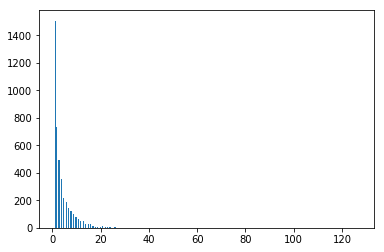

In [14]:
import pickle
import matplotlib.pyplot as plt

latent = pickle.load( open( "data.p", "rb" ) )
print(len(latent))
x = [len(l[0]) for l in latent]
plt.hist(x, bins=250)
plt.show()

In [15]:
%%cython
import pickle
import numpy as np
import matplotlib.pyplot as plt
cimport numpy as np

DTYPE = np.float

cdef double euc(np.ndarray x, np.ndarray y):
    return np.sqrt(np.sum(np.square(x - y)))

cdef double min3(float x, float y, float z):
    cdef float minimum = x
    if y < minimum:
        minimum = y
    if z < minimum:
        minimum = z
    return minimum

cdef double dtw(np.ndarray x, np.ndarray y):
    cdef int n = x.shape[0]
    cdef int m = y.shape[0]
    cdef np.ndarray dp = np.ones((n + 1, m + 1)) * float('inf')
    cdef int i,j
    dp[0,0] = 0.0
    for i in range(1, n + 1):
        for j in range(0, m+1):
            dp[i][j] = euc(x[i - 1, :], y[j - 1, :]) + min3(
                dp[i - 1][j - 1],
                dp[i - 1][j    ],
                dp[i    ][j - 1]
            )
    return dp[n][m]

latent = pickle.load( open( "data.p", "rb" ) )
print(len(latent))
n = len(latent)
distances = np.ones((n, n)) * float('inf')
for i, x in enumerate(latent):
    if i % 10 == 0:
        print("{} / {}".format(i, xxn))
    for j, y in enumerate(latent):
        if abs(len(x[0]) - len(y[0])) < 10 and i < j:  
            distances[i][j] = dtw(x[0], y[0])
pickle.dump(distances, open( "distances.p", "wb" ) )

4263
0 / 4263
10 / 4263
20 / 4263
30 / 4263
40 / 4263
50 / 4263
60 / 4263
70 / 4263
80 / 4263
90 / 4263
100 / 4263
110 / 4263
120 / 4263
130 / 4263
140 / 4263
150 / 4263
160 / 4263
170 / 4263
180 / 4263
190 / 4263
200 / 4263
210 / 4263
220 / 4263
230 / 4263
240 / 4263
250 / 4263
260 / 4263
270 / 4263
280 / 4263
290 / 4263
300 / 4263
310 / 4263
320 / 4263
330 / 4263
340 / 4263
350 / 4263
360 / 4263
370 / 4263
380 / 4263
390 / 4263
400 / 4263
410 / 4263
420 / 4263
430 / 4263
440 / 4263
450 / 4263
460 / 4263
470 / 4263
480 / 4263
490 / 4263
500 / 4263
510 / 4263
520 / 4263
530 / 4263
540 / 4263
550 / 4263
560 / 4263
570 / 4263
580 / 4263
590 / 4263
600 / 4263
610 / 4263
620 / 4263
630 / 4263
640 / 4263
650 / 4263
660 / 4263
670 / 4263
680 / 4263
690 / 4263
700 / 4263
710 / 4263
720 / 4263
730 / 4263
740 / 4263
750 / 4263
760 / 4263
770 / 4263
780 / 4263
790 / 4263
800 / 4263
810 / 4263
820 / 4263
830 / 4263
840 / 4263
850 / 4263
860 / 4263
870 / 4263
880 / 4263
890 / 4263
900 / 4263
910 /

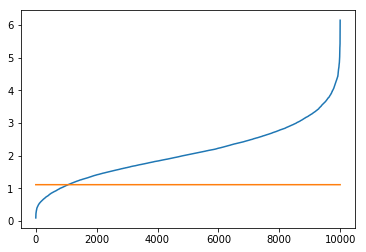

1.1079782313770719


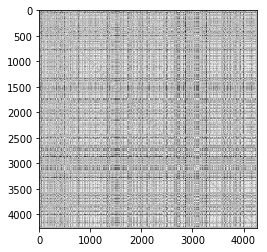

In [16]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import random

latent    = pickle.load( open( "data.p", "rb" ) )
distances = pickle.load( open( "distances.p", "rb" ) )

for i in range(len(distances)):
    for j in range(len(distances)):
        if not np.isinf(distances[i][j]):
            distances[i][j] /= len(latent[i][0]) + len(latent[j][0])

f = [f for f in distances.flatten() if not np.isinf(f)]
random.shuffle(f)
th = np.percentile(f, 10)

plt.plot(sorted(f[0:10000]))
plt.plot(np.ones(10000) * th)
plt.show()
print(th)

for i in range(len(distances)):
    for j in range(len(distances)):
        if np.isinf(distances[i][j]):
            distances[i][j] = distances[j][i]
        if np.isinf(distances[i][j]):
            distances[i][j] = th + 1

plt.imshow(np.mean(distances) - distances, cmap='gray')
plt.show()

In [17]:
pickle.dump(distances, open( "distances_normal.p", "wb" ) )

In [18]:
import pickle
import matplotlib.pyplot as plt
latent = pickle.load( open( "data.p", "rb" ) )
distances = pickle.load( open( "distances_normal.p", "rb" ) )

In [19]:
import sklearn
from sklearn.cluster import AgglomerativeClustering

In [20]:
ac = AgglomerativeClustering(
    n_clusters=None, 
    affinity='precomputed', 
    linkage='complete', 
    distance_threshold=th
)
clusters = ac.fit_predict(distances)

In [21]:
c = [[] for i in range(len(set(clusters)))]
for i, cluster_id in enumerate(clusters):
    latent[i][1:][0]['cluster'] = cluster_id
    c[cluster_id].append(latent[i][1:][0])

In [22]:
final_clustering = [c for c in c if len(c) >= 2]
print(len(final_clustering))
print([len(c) for c in final_clustering])
print(sum([len(c) for c in final_clustering]))

606
[2, 3, 14, 3, 3, 3, 5, 3, 3, 14, 2, 3, 2, 18, 6, 2, 2, 2, 2, 8, 2, 2, 3, 8, 17, 2, 2, 2, 3, 2, 2, 9, 2, 7, 7, 10, 2, 3, 13, 8, 11, 4, 7, 2, 6, 4, 6, 2, 3, 2, 2, 4, 2, 9, 19, 2, 2, 7, 2, 7, 3, 8, 76, 19, 2, 10, 2, 3, 9, 3, 17, 2, 2, 2, 3, 2, 2, 3, 4, 5, 3, 4, 12, 2, 2, 5, 2, 3, 3, 2, 9, 2, 2, 3, 2, 2, 2, 35, 98, 3, 23, 3, 6, 4, 12, 15, 2, 4, 2, 5, 2, 2, 7, 7, 2, 3, 4, 2, 2, 10, 23, 6, 9, 3, 3, 2, 2, 27, 2, 4, 18, 2, 5, 2, 9, 7, 2, 2, 2, 3, 60, 2, 4, 2, 4, 2, 5, 2, 2, 2, 8, 6, 2, 3, 78, 2, 2, 3, 2, 3, 3, 16, 4, 19, 2, 3, 2, 2, 3, 2, 2, 5, 2, 2, 2, 3, 2, 2, 2, 3, 3, 12, 2, 2, 47, 3, 5, 8, 3, 5, 7, 2, 3, 2, 3, 4, 2, 2, 2, 2, 2, 13, 8, 5, 3, 2, 5, 2, 2, 5, 4, 2, 3, 2, 100, 5, 3, 2, 3, 7, 4, 3, 2, 3, 6, 4, 2, 7, 9, 2, 2, 2, 91, 2, 2, 2, 18, 8, 3, 2, 8, 6, 13, 3, 5, 7, 3, 5, 2, 2, 2, 6, 4, 3, 2, 27, 4, 36, 33, 4, 2, 2, 2, 2, 2, 3, 2, 4, 3, 2, 5, 2, 2, 4, 59, 2, 9, 2, 6, 2, 2, 2, 3, 20, 2, 3, 2, 2, 8, 5, 4, 2, 3, 2, 3, 2, 2, 2, 3, 3, 13, 3, 2, 2, 136, 7, 4, 2, 2, 6, 4, 2, 2, 2, 3, 5, 2, 2,

In [26]:
from scipy.io import wavfile

print(len(final_clustering))
print([len(c) for c in final_clustering])

print("CLUSTERS: ", len(final_clustering))
client = storage.Client.from_service_account_json('../secret.json')
bucket = client.get_bucket('wdp-data')
cx = 0
skip = 0
for cluster in final_clustering:
    if cx >= skip:
        n = len(cluster)
        print("Cluster: {}".format(n))
        audio = []
        for i, region in enumerate(cluster):
            path = "audio_files/{}/{}".format(region['year'], region['filename'])
            with open("/tmp/audio.m4a", "wb") as file_obj:
                blob = bucket.blob(path)
                blob.download_to_file(file_obj)
            stream = StreamSpectrogram("/tmp/audio.m4a", [region['start']], [region['stop']])
            spec = fwd_spectrogram(stream.data[region['start']:region['stop']])
            audio.extend(stream.data[region['start']:region['stop']])
            audio.extend(np.zeros(stream.fs // 10))    
        audio = np.array(audio, dtype=audio[0].dtype)
        wavfile.write('../data/results/cluster_{}.wav'.format(cx), stream.fs, audio)
    cx += 1

606
[2, 3, 14, 3, 3, 3, 5, 3, 3, 14, 2, 3, 2, 18, 6, 2, 2, 2, 2, 8, 2, 2, 3, 8, 17, 2, 2, 2, 3, 2, 2, 9, 2, 7, 7, 10, 2, 3, 13, 8, 11, 4, 7, 2, 6, 4, 6, 2, 3, 2, 2, 4, 2, 9, 19, 2, 2, 7, 2, 7, 3, 8, 76, 19, 2, 10, 2, 3, 9, 3, 17, 2, 2, 2, 3, 2, 2, 3, 4, 5, 3, 4, 12, 2, 2, 5, 2, 3, 3, 2, 9, 2, 2, 3, 2, 2, 2, 35, 98, 3, 23, 3, 6, 4, 12, 15, 2, 4, 2, 5, 2, 2, 7, 7, 2, 3, 4, 2, 2, 10, 23, 6, 9, 3, 3, 2, 2, 27, 2, 4, 18, 2, 5, 2, 9, 7, 2, 2, 2, 3, 60, 2, 4, 2, 4, 2, 5, 2, 2, 2, 8, 6, 2, 3, 78, 2, 2, 3, 2, 3, 3, 16, 4, 19, 2, 3, 2, 2, 3, 2, 2, 5, 2, 2, 2, 3, 2, 2, 2, 3, 3, 12, 2, 2, 47, 3, 5, 8, 3, 5, 7, 2, 3, 2, 3, 4, 2, 2, 2, 2, 2, 13, 8, 5, 3, 2, 5, 2, 2, 5, 4, 2, 3, 2, 100, 5, 3, 2, 3, 7, 4, 3, 2, 3, 6, 4, 2, 7, 9, 2, 2, 2, 91, 2, 2, 2, 18, 8, 3, 2, 8, 6, 13, 3, 5, 7, 3, 5, 2, 2, 2, 6, 4, 3, 2, 27, 4, 36, 33, 4, 2, 2, 2, 2, 2, 3, 2, 4, 3, 2, 5, 2, 2, 4, 59, 2, 9, 2, 6, 2, 2, 2, 3, 20, 2, 3, 2, 2, 8, 5, 4, 2, 3, 2, 3, 2, 2, 2, 3, 3, 13, 3, 2, 2, 136, 7, 4, 2, 2, 6, 4, 2, 2, 2, 3, 5, 2, 2,

NameError: name 'audio' is not defined

In [23]:
max_id = run_query("""
    SELECT 
        max(id)
    FROM 
        wdp_ds.clustering_results
    """)
if max_id[0]['max(id)'] is None:
    max_id = 0
else:
    max_id = max_id[0]['max(id)']
print(max_id)

0


In [24]:
with db.connect() as conn:
    id = 0
    for cluster in final_clustering:
        for r in cluster:
            query = "INSERT INTO wdp_ds.clustering_results VALUES({}, {}, '{}', {}, {}, '{}', {}, CURRENT_TIMESTAMP)".format(
                id, r['encoding'], r['filename'], r['start'], r['stop'], 'agglomerative_dtw_lstm_v2', r['cluster'])        
            conn.execute(query)  
            id += 1